# Segmentation of the problem /area 
Segmentation of the area into components consisting of inaccessible patches + their accessible neighbors

**Steps to create the segments**
1. dissolve component stands into one big geometry
2. find the "ring of (already fully accessible) neighbors" of the component
    together, this will be one problem area (component and neighbors). then the next steps are to define the exit points to public road
3. merge component and neighbors to create basis for future road network

BONUS
4. check if the river is there somewhere in the middle of a component


## Imports & Settings

### 📦 Library imports

In [1]:
## Standard library imports
import os
import re
import json
import csv
import random
from collections import Counter

# Third-party libraries
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy.spatial import Delaunay

# Geospatial processing
from shapely.ops import unary_union, nearest_points, snap
from shapely.geometry import Polygon, MultiPolygon, LineString, Point, MultiPoint

# Graph processing
import networkx as nx

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.colors import LinearSegmentedColormap

import itertools

### ⚙️ Global settings

In [2]:
# Set global default settings
plt.rcParams.update({
    'axes.labelsize': 0,  # Remove axis labels
    'axes.titlesize': 0,  # Remove title size
    'axes.linewidth': 0,  # Remove axis borders
    'axes.grid': False,  # Disable grid
    'xtick.bottom': False,  # Disable x-axis ticks
    'ytick.left': False,  # Disable y-axis ticks
    'xtick.labelsize': 0,  # Hide x-axis labels
    'ytick.labelsize': 0,  # Hide y-axis labels
    'axes.spines.top': False,  # Remove top axis border
    'axes.spines.right': False,  # Remove right axis border
    'axes.spines.left': False,  # Remove left axis border
    'axes.spines.bottom': False  # Remove bottom axis border
})


## 📂 Load data

### 🌲 load stands 

In [ ]:
# Define path
shapefile = r "1_Preprocessed_Data\0_Forest_Management_Units_cleaned\fixed_snapped_opt1-1m-manually-cleaned.shp"

# Load geodata and fix invalid geometries
allstands_gdf = gpd.read_file(shapefile)#.assign(geometry=lambda df: df.geometry.buffer(0))
print(f"{len(allstands_gdf)} stands in total")

687 stands in total


In [4]:
# Load accessibility data
in_path = "1_Preprocessed_Data/1_Stand_Accessibility"
files = {
    "accessible": "stands_accessible.csv",
    "timber road only": "stands_timberroadonly.csv",
    "no road access": "stands_inaccessible.csv",
}

dfs = {k: pd.read_csv(f"{in_path}/{v}") for k, v in files.items()}
for k, df in dfs.items():
    print(f"{len(df)} stands are {k}")

324 stands are accessible
151 stands are timber road only
212 stands are no road access


In [5]:
# Merge geospatial data with inaccessibility list
stands_gdf = allstands_gdf.merge(dfs["no road access"], on="ID_UG", how="inner")
print(f"{len(stands_gdf)} stands after merging list of inaccessible with allstands_gdf\n")
stands_gdf.head(1)

212 stands after merging list of inaccessible with allstands_gdf



,OBJECTID,TARGET_FID,LandUse_1,Ocupacao,ID_UG,NOME,YY_correct,XX_Correct,Altitude,Declive,...,Area,Hectares,UsoSolo20,Shape_Leng,Shape_Area,HBC,CH,CBD,CC,geometry
0,131,761,1,EcEc_2_3_3_Pv,840,Castelo de Paiva,152302.982524,-20400.888754,215.0,22.5796,...,73670.927386,7.367093,Eucalipto,1191.720013,73670.935166,2.9,0.0,0.0,0.0,"POLYGON ((-20161.533 152306.823, -20213.551 15..."


In [6]:
# Merge GeoData with the list of stands using the previously defined dfs dictionary
accessible_stands_gdf = allstands_gdf.merge(dfs["accessible"], on="ID_UG", how="inner")
timberroad_stands_gdf = allstands_gdf.merge(dfs["timber road only"], on="ID_UG", how="inner")
inaccessible_stands_gdf = allstands_gdf.merge(dfs["no road access"], on="ID_UG", how="inner")

#### visualize

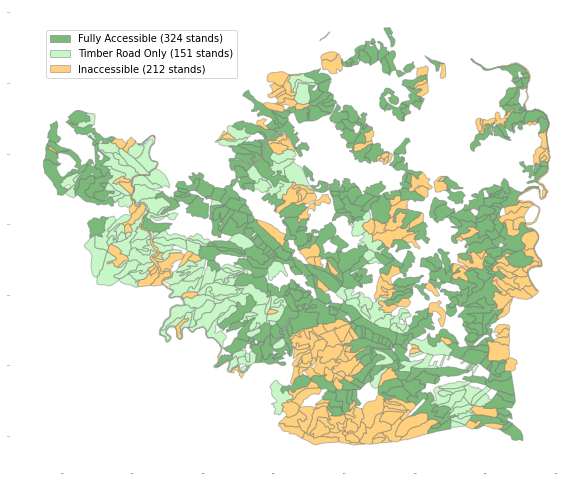

In [7]:
# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot each category of stands explicitly
accessible_stands_gdf.plot(ax=ax, color='forestgreen', edgecolor='grey', label=f'Fully Accessible ({len(accessible_stands_gdf)} stands)', alpha=0.6)
timberroad_stands_gdf.plot(ax=ax, color='lightgreen', edgecolor='grey', label=f'Timber Road Only ({len(timberroad_stands_gdf)} stands)', alpha=0.5)
inaccessible_stands_gdf.plot(ax=ax, color='orange', edgecolor='grey', label=f'Inaccessible ({len(inaccessible_stands_gdf)} stands)', alpha=0.5)

# Create custom legend with explicit labels
legend_labels = [
    Patch(facecolor='forestgreen', edgecolor='grey', label=f'Fully Accessible ({len(accessible_stands_gdf)} stands)', alpha=0.6),
    Patch(facecolor='lightgreen', edgecolor='grey', label=f'Timber Road Only ({len(timberroad_stands_gdf)} stands)', alpha=0.5),
    Patch(facecolor='orange', edgecolor='grey', label=f'Inaccessible ({len(inaccessible_stands_gdf)} stands)', alpha=0.5)
]

# Add legend to the plot with modified position (bottom left corner)
ax.legend(handles=legend_labels, bbox_to_anchor=(0.05, 0.95), loc='upper left', borderaxespad=0.)

# Display the plot
plt.show()


### 🛤️ load road data

In [8]:
# Define folder path for road data
road_folder = "1_Preprocessed_Data/1_Roads_clean"

#### 🛣️🛤️ all roads

In [9]:
# Load the 'all roads' dataset
allroads_gdf = gpd.read_file(f"1_Preprocessed_Data/1_Roads_clean/roads_clean.shp")

# Align CRS of allroads_gdf to the CRS of allstands_gdf
allroads_gdf = allroads_gdf.to_crs(allstands_gdf.crs)

# Check CRS alignment for allroads_gdf (optional)
print(f"CRS of allroads_gdf: {allroads_gdf.crs}")

# Print the number of roads loaded and preview the first row
print(f"{len(allroads_gdf)} total roads loaded")
allroads_gdf.head(1)

CRS of allroads_gdf: PROJCRS["ETRS89 / Portugal TM06",BASEGEOGCRS["ETRS89",DATUM["European Terrestrial Reference System 1989",ELLIPSOID["GRS 1980",6378137,298.257222101,LENGTHUNIT["metre",1]],ID["EPSG",6258]],PRIMEM["Greenwich",0,ANGLEUNIT["Degree",0.0174532925199433]]],CONVERSION["unnamed",METHOD["Transverse Mercator",ID["EPSG",9807]],PARAMETER["Latitude of natural origin",39.6682583333333,ANGLEUNIT["Degree",0.0174532925199433],ID["EPSG",8801]],PARAMETER["Longitude of natural origin",-8.13310833333333,ANGLEUNIT["Degree",0.0174532925199433],ID["EPSG",8802]],PARAMETER["Scale factor at natural origin",1,SCALEUNIT["unity",1],ID["EPSG",8805]],PARAMETER["False easting",0,LENGTHUNIT["metre",1],ID["EPSG",8806]],PARAMETER["False northing",0,LENGTHUNIT["metre",1],ID["EPSG",8807]]],CS[Cartesian,3],AXIS["(E)",east,ORDER[1],LENGTHUNIT["metre",1,ID["EPSG",9001]]],AXIS["(N)",north,ORDER[2],LENGTHUNIT["metre",1,ID["EPSG",9001]]],AXIS["ellipsoidal height (h)",up,ORDER[3],LENGTHUNIT["metre",1,ID["EPSG"

,Id,ID_RV,DATA_ACCAO,COD_INE,DESIGNACAO,OPERAC,REDE_DFCI,TIPO_PISO,COMPRIM,LARGURA,...,FIN_2017,FASE_2017,TIPO_VEICU,INTER_2018,EXEC_2018,FIN_2018,FASE_2018,OBSERV,ROADWIDTH,geometry
0,1,1,2011-01-31,10609,VARIANTE EN222,OPER,1,A,1398.32,0.0,...,0,0,VTTR,ESI,0,0,0,NaN,10,"LINESTRING (-11588.474 151775.913, -11614.929 ..."


#### 🛣️ bigroads

In [10]:
# Load the 'big roads' dataset
#bigroads_gdf = gpd.read_file(f"1_Preprocessed_Data/1_Roads_clean/bigroads_clean.shp")

# Align CRS of bigroads_gdf to the CRS of allstands_gdf
#bigroads_gdf = bigroads_gdf.to_crs(allstands_gdf.crs)

# Check CRS alignment for bigroads_gdf (optional)
#print(f"CRS of bigroads_gdf: {bigroads_gdf.crs}")

# Print the number of wide roads loaded and preview the first row
#print(f"{len(bigroads_gdf)} wide roads loaded")
#bigroads_gdf.head(1)

### 🌊 load river data

In [11]:
# Load the rivers GeoDataFrame from a GeoPackage file
rivers_gdf = gpd.read_file(r'2_Additionally_used_data\Selected_subset\Rivers_CDP.gpkg')

# Align the CRS of the rivers GeoDataFrame to match the CRS of allstands_gdf
rivers_gdf = rivers_gdf.to_crs(allstands_gdf.crs)

# Print the number of rows in the rivers GeoDataFrame
print(f"{len(rivers_gdf)} rivers loaded")

# Display the first row of the rivers GeoDataFrame
rivers_gdf.head(1)

59 rivers loaded


,OBJECTID,DFDD,RN_I_ID,REX,HYP,LOC,FUN,NVS,LENGTH,TR,...,TNODE,STRAHLER,nameTxtInt,nameText,NEXTUPID,NEXTDOWNID,FNODE,CatchID,PFAFSTETTER,geometry
0,4405,BH140,NaN,PT,1.0,44.0,6.0,5.0,4416.72998,NA,...,NO15004431,1.0,NaN,NaN,NaN,RL15004502,NO15004430,226,NaN,MULTILINESTRING Z ((-12976.644 142597.803 312....


#### visualize

## basic data preps

#### geometry types

In [12]:
# unique geometry types
unique_geom_types = stands_gdf.geom_type.unique()
print("Unique Geometry Types:", unique_geom_types)

Unique Geometry Types: ['Polygon']


#### check for overlaps

In [13]:
overlaps = stands_gdf.overlay(stands_gdf, how="intersection", keep_geom_type=False)
overlaps = overlaps[overlaps.geometry.area > 0]  # Remove zero-area self-intersections

if not overlaps.empty:
    print("Overlapping areas detected.")
else:
    print("No overlaps found.")


Overlapping areas detected.


#### check for gaps

In [14]:
# Create a union of all geometries to check for gaps
union_geom = stands_gdf.unary_union

# Find gaps by subtracting the union from the total bounding box
bounding_box = Polygon.from_bounds(*stands_gdf.total_bounds)
gaps = bounding_box.difference(union_geom)

# Check if gaps exist
if gaps.is_empty:
    print("No gaps detected.")
else:
    print("Gaps found in the dataset.")


Gaps found in the dataset.


## 🧩 Identify "patches" of inaccessible stands

We have a couple of forest stand "patches" that are separated from each other by areas that are already accessible.

This segmentation of the study area allows to "split"" original problem into smaller problems, that can be solved seperately, which improves runtime etc.

Let's identify those "patches" / segments:

### 0. model inaccessible stands as graph
Take all stands that are not connected to roads yet.

Treat each stand as a node and create edges between nodes that are touching (intersecting geometrically).

use a 1m buffer when creating the graph

In [15]:
out_path = "1_Preprocessed_Data/2_Stand_Components/unconnected_to_roads"
#out_path = "1_Preprocessed_Data/Stand_Components/unconnected_to_bigroads"
os.makedirs(out_path, exist_ok=True)

In [16]:
# Initialize an empty undirected graph
G = nx.Graph()

# working with a copy of the stands GeoDataFrame
stands_gdf = stands_gdf.copy()

# Apply a 1-meter buffer to each stand geometry and store it in the GeoDataFrame
stands_gdf['buffered_geometry'] = stands_gdf['geometry'].buffer(1.0)  # 1-meter buffer

# Add nodes to the graph using 'ID_UG' as the node label and buffered geometry
for _, row in stands_gdf.iterrows():
    G.add_node(row['ID_UG'], geometry=row['buffered_geometry'])

# Create edges between stands whose buffered geometries intersect
for (i, row_i), (j, row_j) in itertools.combinations(stands_gdf.iterrows(), 2):
    if row_i['buffered_geometry'].intersects(row_j['buffered_geometry']):
        G.add_edge(row_i['ID_UG'], row_j['ID_UG'])

# Remove the temporary buffered geometry column (optional)
stands_gdf = stands_gdf.drop(columns=['buffered_geometry'])

print('Graph created ( with 1-meter buffer) around each stand.')

# verify
num_nodes = G.number_of_nodes()
print('Nodes:', num_nodes,)

Graph created ( with 1-meter buffer) around each stand.
Nodes: 212


#### visualize graph of inaccessible stands

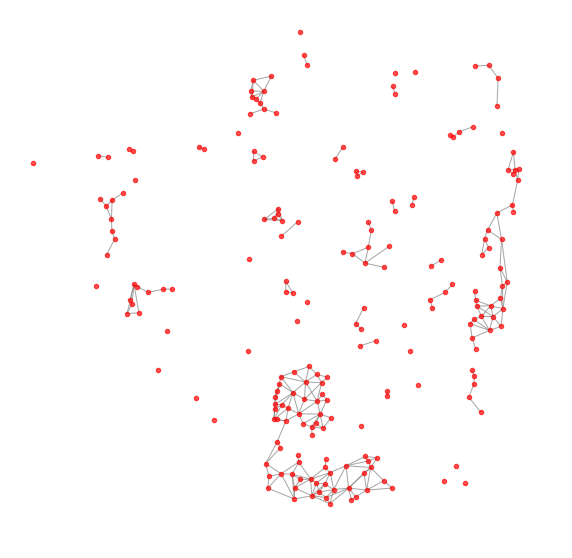

In [17]:
# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Get positions of nodes based on the centroid of each stand's geometry
pos = {node: (stand['geometry'].centroid.x, stand['geometry'].centroid.y) 
       for node, stand in G.nodes(data=True)}

# Draw the graph with some enhanced styling
nx.draw(G, pos, ax=ax, with_labels=False, node_size=20, node_color='red', 
        font_size=8, font_color='black', alpha=0.7, edge_color='gray')

# Save and display the plot
plt.savefig(f"{out_path}/graph_of_stands_with_buffer.png")
plt.show()

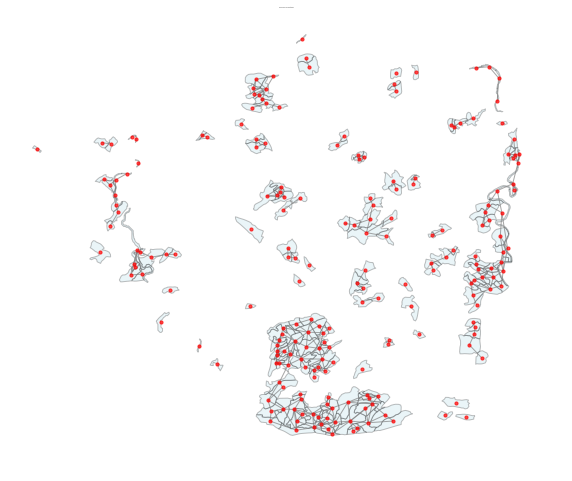

In [18]:
# doublecheck with geometries
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the geometries of the stands
stands_gdf.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.25)

# Get node positions based on the centroid of each stand geometry
pos = {node: (stand['geometry'].centroid.x, stand['geometry'].centroid.y) 
       for node, stand in G.nodes(data=True)}

# Draw the graph nodes and edges
nx.draw(G, pos, ax=ax, with_labels=False, node_size=10, node_color='red', 
        font_size=8, font_color='black', alpha=0.7, edge_color='gray')

plt.title("Graph of Inaccessible stands")

# Save and show the plot
plt.savefig(f"{out_path}/inaccessible_components_with_graph.png")
plt.show()

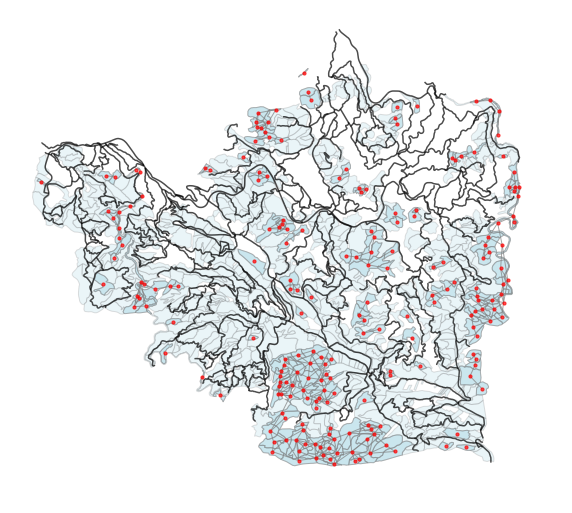

In [19]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the geometries of the stands
stands_gdf.plot(ax=ax, color='lightblue', edgecolor='grey', alpha=0.5)

# Plot the roads (assuming roads_gdf is your GeoDataFrame with road data)
allroads_gdf.plot(ax=ax, color='black', alpha=0.7)

# Plot the other stands
allstands_gdf.plot(ax=ax, color='lightblue', edgecolor='grey', alpha=0.25)

# Get node positions based on the centroid of each stand geometry
pos = {node: (stand['geometry'].centroid.x, stand['geometry'].centroid.y) 
       for node, stand in G.nodes(data=True)}

# Draw the graph nodes and edges
nx.draw(G, pos, ax=ax, with_labels=False, node_size=10, node_color='red', 
        font_size=8, font_color='black', alpha=0.7, edge_color='gray')

# Save and show the plot
plt.savefig(f"{out_path}/inaccessible_components_with_graph_with_roads_with_allstands.png")
plt.show()


### 1. identify connected components

In [20]:
connected_components = list(nx.connected_components(G))  # List of sets of connected nodes

# Create a dictionary where the key is the component index (starting from 1) and the value is the set of nodes in that component
components_dict = {i+1: component for i, component in enumerate(connected_components)}

print('Connected components (= Inaccessible "patches"):', len(components_dict))

Connected components (= Inaccessible "patches"): 51


In [21]:
# Print the dictionary of components
for component_id, component in components_dict.items():
    print(f"Component {component_id}: {component}")

Component 1: {840, 841}
Component 2: {1556, 846}
Component 3: {1437, 1439, 1184, 1441, 1186, 1442, 1440, 1185, 1483, 1444, 1445, 1443, 1197, 1072, 1074, 1075, 1204, 1077, 1078, 1079, 1080, 1081, 1083, 1084, 1085, 1086, 1087, 1088, 1600, 1480, 1481, 1482, 1611, 1612, 1613, 1614, 1615, 1616, 1488, 1487, 1363, 1484, 1364, 1485, 1620, 1123, 1124, 1125, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1137, 1138, 1140, 1141, 1142, 1143, 1144, 1145, 1270, 1534}
Component 4: {900, 1387, 1388, 1206}
Component 5: {1520, 1519}
Component 6: {1284, 1231, 1424, 1423, 851, 852, 821, 822, 1555, 853}
Component 7: {907, 908, 1323, 913, 914, 1561, 1562, 1563}
Component 8: {1148}
Component 9: {1153}
Component 10: {903, 1042, 1044, 1045, 1046, 1431, 1048, 1050, 1051, 1052, 1053, 1054, 1567, 1056, 1055, 1568, 1573, 1574, 1575, 1576, 1577, 1585, 819, 1606, 980, 981, 982, 983, 1385, 1263, 1275}
Component 11: {1468, 1182}
Component 12: {942, 945, 947, 1469, 1470}
Component 13: {549}
Component 14: {824, 827}
Componen

### 💾 save components [helper functions]

#### [helper function] save components gdf to csv

In [22]:
def store_components_csv(components_dict, output_dir, file_format='csv'):
    """
    Store each component from the dictionary in separate files.
    
    Parameters:
    - components_dict (dict): Dictionary of components (key is component_id, value is a set of stands).
    - output_dir (str): Directory to save the component files. Defaults to 'components_files'.
    - file_format (str): Format to save the components in, either 'json' or 'csv'. Defaults to 'json'.
    
    """

    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Loop through the dictionary and store each component in its own file
    for component_id, component in components_dict.items():
        # Define file name based on component_id
        file_name = f'component_{component_id}'
        output_file = os.path.join(output_dir, f'{file_name}.{file_format}')
        
        with open(output_file, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['Component ID', 'Stand'])  # Write header
            for stand in component:
                writer.writerow([component_id, stand])  # Write component and stand
        #print(f"Component {component_id} saved to {output_file}")

#### [helper function]  save stands per component to shapefile [helper function]

In [23]:
def save_stands_shp_and_graph_png_per_component(out_path, stands_gdf, components_dict, G):
    """
    Save the stands and graphs for each connected component.

    Parameters:
    - out_path: Directory where the outputs will be saved.
    - stands_gdf: GeoDataFrame containing the stands (parcels) geometries.
    - components_dict: Dictionary where keys are component IDs and values are sets of stand IDs.
    - G: NetworkX graph representing the relationship between the stands.
    """
    # Ensure output directory exists
    os.makedirs(out_path, exist_ok=True)

    # Iterate over the components_dict
    for component_id, component in components_dict.items():
        # Convert the component (a set of node IDs) into a GeoDataFrame and save it as a shapefile
        component_gdf = stands_gdf[stands_gdf['ID_UG'].isin(component)]  # Get the stands for this component
        component_gdf.to_file(os.path.join(out_path, f"component_{component_id}_stands.shp"))

        # Save the list of IDs (UGs) for this component
        ug_list_file = os.path.join(out_path, f"component_{component_id}_stands.txt")
        with open(ug_list_file, "w") as f:
            f.write(f"ID_UG\n")
            for node in component:
                f.write(f"{node}\n")

        # Filter stands that are part of this component
        stands_in_component = stands_gdf[stands_gdf['ID_UG'].isin(component)]

        # Create a subgraph for the component
        subgraph = G.subgraph(component)

        # Get node positions based on centroids for the subgraph
        pos = {node: (stand['geometry'].centroid.x, stand['geometry'].centroid.y) 
               for node, stand in subgraph.nodes(data=True)}

        # Plot the filtered stands and the subgraph together
        fig, ax = plt.subplots(figsize=(10, 10))

        # Plot the stands that are in the current component
        stands_in_component.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.5)

        # Plot the subgraph (nodes and edges)
        nx.draw(subgraph, pos, ax=ax, with_labels=False, node_size=20, node_color='red', 
                font_size=8, font_color='black', alpha=0.7, edge_color='gray')

        # Add node labels (UG IDs) to the plot
        nx.draw_networkx_labels(subgraph, pos, font_size=10, font_color='black', font_weight='bold')

        # Add a title to the plot
        plt.title(f"Component {component_id} ({len(subgraph)} stands)")

        # Save the plot
        plot_file = os.path.join(out_path, f"component_{component_id}_stands_with_graph.png")
        plt.savefig(plot_file)
        plt.close()

    # Print message upon successful saving
    print(f"Saved {len(components_dict)} component lists and graphs to '{out_path}'")

#### 💾 save all inaccessible components

In [24]:
store_components_csv(components_dict, output_dir=os.path.join(out_path, '0_all_inaccessible_components'), file_format='csv')
print(f"Components csv saved.")
cpath = os.path.join(out_path, "0_all_inaccessible_components")
save_stands_shp_and_graph_png_per_component(cpath, stands_gdf, components_dict, G)

Components csv saved.
Saved 51 component lists and graphs to '1_Preprocessed_Data/2_Stand_Components/unconnected_to_roads\0_all_inaccessible_components'


### 2. distinguish between components by size (number of stands contained)

In [25]:
# Count the sizes of the connected components (length of each set of nodes)
component_sizes = [len(component) for component in components_dict.values()]

# Use Counter to get the frequency of each component size
size_counts = Counter(component_sizes)

# Print the overview of component sizes and their frequencies
for size, count in sorted(size_counts.items()):
    print(f"Components with {size} parcels: {count}")

Components with 1 parcels: 25
Components with 2 parcels: 11
Components with 3 parcels: 4
Components with 4 parcels: 3
Components with 5 parcels: 2
Components with 8 parcels: 2
Components with 9 parcels: 1
Components with 10 parcels: 1
Components with 31 parcels: 1
Components with 65 parcels: 1


#### 🎨 Colormap

In [26]:
cmap = plt.get_cmap('tab10', len(connected_components))  # 'tab10' is good for categorical data
colors = [cmap(i) for i in range(len(connected_components))]

#### visualize components sizes

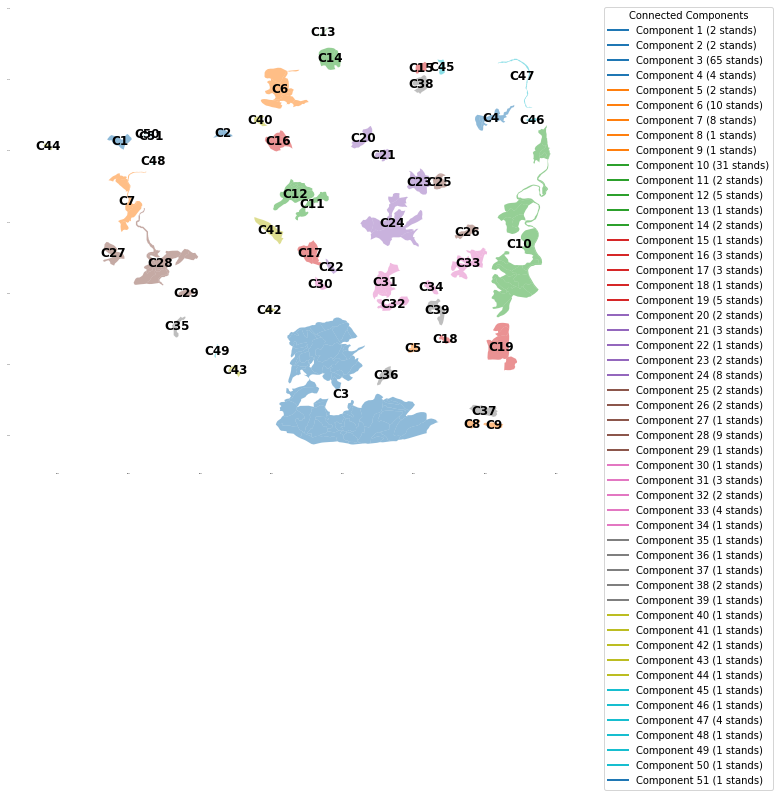

In [27]:
# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))

legend_handles = []

# Loop through each connected component and plot
for comp_id, component in components_dict.items():  # Use dictionary items instead of enumerate
    # Assuming each 'component' in components_dict is a list of nodes (parcels)
    component_gdf = stands_gdf[stands_gdf['ID_UG'].isin(component)]  # Replace 'ID_UG' with your actual ID column
    
    # Choose a color for the component
    color = colors[comp_id % len(colors)]

    # Plot the component
    component_gdf.plot(ax=ax, color=color, alpha=0.5)

    # Compute centroid for labeling
    centroid = component_gdf.geometry.unary_union.centroid
    ax.text(centroid.x, centroid.y, f'C{comp_id}', fontsize=12, ha='center', va='center', color='black', weight='bold')

    # Create a custom legend handle
    legend_handles.append(Line2D([0], [0], color=color, lw=2, label=f'Component {comp_id} ({len(component)} stands)'))

# Create a custom legend outside the plot
ax.legend(handles=legend_handles, title="Connected Components", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Show the plot
plt.show()


### 3. 🏝️ identify isolated nodes

In [28]:
# Identify isolated nodes (single-node connected components)
isolated_nodes = [component.pop() for component in connected_components if len(component) == 1]

#### save isolated nodes

In [29]:
# Save isolated nodes to a file
isolated_nodes_file = os.path.join(out_path, "2_single_inaccessible_stands.txt")
with open(isolated_nodes_file, "w") as f:
    f.write(f"ID_UG of isolated stands\n")
    for node in isolated_nodes:
        f.write(f"{node}\n")

print(f"Saved {len(isolated_nodes)} isolated nodes to {isolated_nodes_file}")

Saved 25 isolated nodes to 1_Preprocessed_Data/2_Stand_Components/unconnected_to_roads\2_single_inaccessible_stands.txt


#### visualize isolated

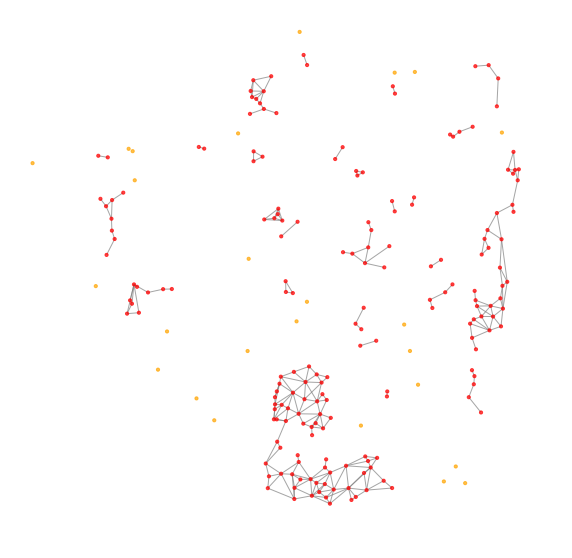

In [30]:
# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Get positions of nodes based on the centroid of each stand's geometry
pos = {node: (stand['geometry'].centroid.x, stand['geometry'].centroid.y) 
       for node, stand in G.nodes(data=True)}

# Define node colors: isolated nodes in orange, others in red
node_colors = ['orange' if node in isolated_nodes else 'red' for node in G.nodes()]

# Draw the graph
nx.draw(G, pos, ax=ax, with_labels=False, node_size=10, node_color=node_colors, 
        font_size=8, font_color='black', alpha=0.7, edge_color='gray')

# Save and display the plot
plt.savefig(f"{out_path}/graph_of_stands_with_buffer.png")
plt.show()

### 4. remove isolated nodes

In [31]:
# Remove isolated nodes from the graph
G.remove_nodes_from(isolated_nodes)

print(f"Removed {len(isolated_nodes)} isolated nodes.")

# Remove isolated stands from a copy of stands_gdf
remaining_stands_gdf = stands_gdf[~stands_gdf['ID_UG'].isin(isolated_nodes)].copy()

Removed 25 isolated nodes.


#### update dict for storage

In [32]:
# Get the connected components after removing isolated nodes
connected_components = list(nx.connected_components(G))

# Create a dictionary to store the connected components
components_dict = {i+1: component for i, component in enumerate(connected_components)}

# Print the components dictionary (Optional)
print(f"New components dictionary with {len(components_dict)} components:")
for component_id, component in components_dict.items():
    print(f"Component {component_id}: {component}")

New components dictionary with 26 components:
Component 1: {840, 841}
Component 2: {1556, 846}
Component 3: {1437, 1439, 1184, 1441, 1186, 1442, 1440, 1185, 1483, 1444, 1445, 1443, 1197, 1072, 1074, 1075, 1204, 1077, 1078, 1079, 1080, 1081, 1083, 1084, 1085, 1086, 1087, 1088, 1600, 1480, 1481, 1482, 1611, 1612, 1613, 1614, 1615, 1616, 1488, 1487, 1363, 1484, 1364, 1485, 1620, 1123, 1124, 1125, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1137, 1138, 1140, 1141, 1142, 1143, 1144, 1145, 1270, 1534}
Component 4: {900, 1387, 1388, 1206}
Component 5: {1520, 1519}
Component 6: {1284, 1231, 1424, 1423, 851, 852, 821, 822, 1555, 853}
Component 7: {907, 908, 1323, 913, 914, 1561, 1562, 1563}
Component 8: {903, 1042, 1044, 1045, 1046, 1431, 1048, 1050, 1051, 1052, 1053, 1054, 1567, 1056, 1055, 1568, 1573, 1574, 1575, 1576, 1577, 1585, 819, 1606, 980, 981, 982, 983, 1385, 1263, 1275}
Component 9: {1468, 1182}
Component 10: {942, 945, 947, 1469, 1470}
Component 11: {824, 827}
Component 12: {857, 882,

#### verify removal of isolated

In [33]:
print(isolated_nodes)

[1148, 1153, 549, 833, 1109, 920, 984, 999, 1014, 1039, 1058, 1105, 1213, 1256, 1299, 1339, 1360, 1436, 1530, 1538, 1541, 1558, 1560, 1582, 1584]


In [34]:
# verify
num_nodes = G.number_of_nodes()
print(num_nodes)

187


#### visualize after removal

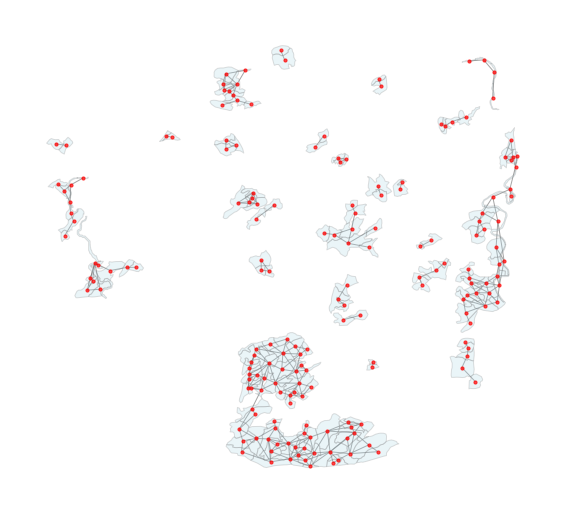

In [35]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Get node positions based on the centroid of each stand geometry
pos = {node: (stand['geometry'].centroid.x, stand['geometry'].centroid.y) 
       for node, stand in G.nodes(data=True)}

# Draw the graph nodes and edges
nx.draw(G, pos, ax=ax, with_labels=False, node_size=10, node_color='red', 
        font_size=8, font_color='black', alpha=0.7, edge_color='gray')

# Add the filtered stands to the plot
remaining_stands_gdf.plot(ax=ax, color='lightblue', edgecolor='grey', alpha=0.25)

# Save and show the plot
plt.savefig(f"{out_path}/graph_of_touching_stands.png")
plt.show()

#### new colormap

In [36]:
# Generate a colormap excluding green shades
excluded_colors = ['#FF0000', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF', '#800000', 
                   '#808000', '#800080', '#008080', '#FFA500', '#A52A2A', '#FFC0CB']

# Create a color map with excluded green shades
colors = np.random.choice(excluded_colors, size=len(connected_components), replace=True)

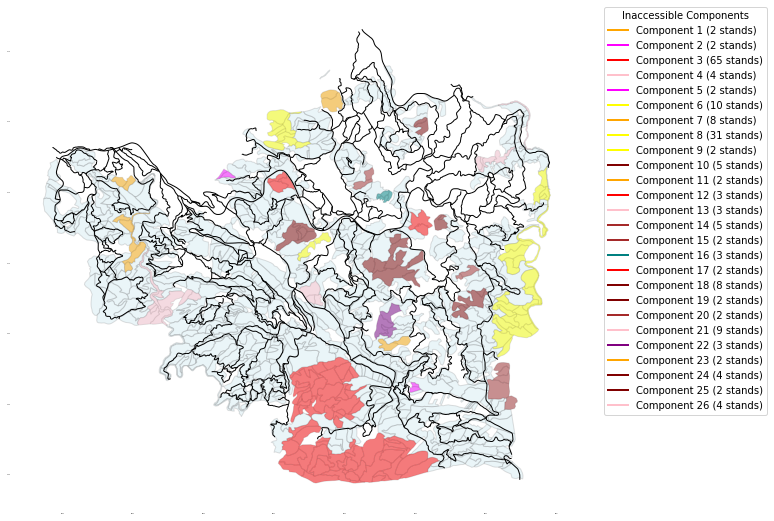

In [37]:
# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))

legend_handles = []

# Plot all stands_gdf (this is done outside the loop for efficiency)
allstands_gdf.plot(ax=ax, color='lightblue', edgecolor='grey', alpha=0.25, label='Stands')

# Plot allroads_gdf (this is also done outside the loop)
allroads_gdf.plot(ax=ax, color='black', linewidth=1, label='Roads')

# Loop through each connected component in components_dict
for component_id, component in components_dict.items():
    # Assuming each 'component' in components_dict is a set of nodes (parcels)
    component_gdf = stands_gdf[stands_gdf['ID_UG'].isin(component)]  # Replace 'ID_UG' with your actual ID column
    
    # Choose a color for the component
    color = colors[component_id % len(colors)]  # Use component_id for consistent coloring

    # Plot the component
    component_gdf.plot(ax=ax, color=color, alpha=0.5)

    # Create a custom legend handle for this component
    legend_handles.append(Line2D([0], [0], color=color, lw=2, label=f'Component {component_id} ({len(component)} stands)'))

# Create a custom legend outside the plot
ax.legend(handles=legend_handles, title="Inaccessible Components", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Show the plot
plt.show()

## 💾 save nonsingle components

In [38]:
out_path = "1_Preprocessed_Data/2_Stand_Components/unconnected_to_roads"
store_components_csv(components_dict, output_dir=os.path.join(out_path, '1_nonsingle_inaccessible_components'), file_format='csv')
print(f"Components csv saved.")
cpath = os.path.join(out_path, "1_nonsingle_inaccessible_components")
save_stands_shp_and_graph_png_per_component(cpath, stands_gdf, components_dict, G)

Components csv saved.
Saved 26 component lists and graphs to '1_Preprocessed_Data/2_Stand_Components/unconnected_to_roads\1_nonsingle_inaccessible_components'


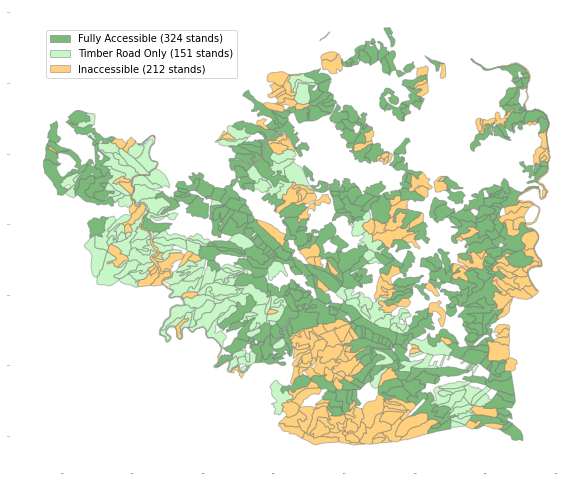

In [39]:
# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot each category of stands explicitly
accessible_stands_gdf.plot(ax=ax, color='forestgreen', edgecolor='grey', label=f'Fully Accessible ({len(accessible_stands_gdf)} stands)', alpha=0.6)
timberroad_stands_gdf.plot(ax=ax, color='lightgreen', edgecolor='grey', label=f'Timber Road Only ({len(timberroad_stands_gdf)} stands)', alpha=0.5)
inaccessible_stands_gdf.plot(ax=ax, color='orange', edgecolor='grey', label=f'Inaccessible ({len(inaccessible_stands_gdf)} stands)', alpha=0.5)

# Create custom legend with explicit labels
legend_labels = [
    Patch(facecolor='forestgreen', edgecolor='grey', label=f'Fully Accessible ({len(accessible_stands_gdf)} stands)', alpha=0.6),
    Patch(facecolor='lightgreen', edgecolor='grey', label=f'Timber Road Only ({len(timberroad_stands_gdf)} stands)', alpha=0.5),
    Patch(facecolor='orange', edgecolor='grey', label=f'Inaccessible ({len(inaccessible_stands_gdf)} stands)', alpha=0.5)
]

# Add legend to the plot with modified position (bottom left corner)
ax.legend(handles=legend_labels, bbox_to_anchor=(0.05, 0.95), loc='upper left', borderaxespad=0.)

# Display the plot
plt.show()

## ⭕ combine with ring of neighbors
- dissolve inaccessible into big component
- find ring of neighbors
- store components including ring of neighbors

In [40]:
# Initialize a dictionary to store all combined components
all_combi_components = {}

combined_gdf = gpd.GeoDataFrame()  # Initialize an empty GeoDataFrame

# Iterate over the components_dict
for component_id, component in components_dict.items():
    # Get the component and non-component GeoDataFrames
    component_gdf = stands_gdf[stands_gdf['ID_UG'].isin(component)].copy()
    non_component_gdf = allstands_gdf[~allstands_gdf['ID_UG'].isin(component)].copy()

    # Dissolve the component into a single geometry
    dissolved_component_gdf = component_gdf.dissolve()
    
    # Apply a buffer to find neighboring stands
    buffer_gdf = dissolved_component_gdf.copy()
    buffer_gdf['geometry'] = buffer_gdf.geometry.buffer(1.0)  # 1-meter buffer
    
    # Find neighboring stands using intersection with the buffer geometry
    neighbors_gdf = non_component_gdf[non_component_gdf.geometry.intersects(buffer_gdf.geometry.unary_union)].copy()
    
    # Mark accessibility
    component_gdf['access'] = 'inaccessible'
    neighbors_gdf['access'] = 'accessible'
    
    # Append to the combined GeoDataFrame
    combined_gdf = pd.concat([combined_gdf, component_gdf, neighbors_gdf], ignore_index=True)

    # Create a separate GeoDataFrame for this component
    combi_component_gdf = pd.concat([component_gdf, neighbors_gdf], ignore_index=True)

    # Store in dictionary for later use
    all_combi_components[f"{component_id}"] = combi_component_gdf

## 💾 Save components including ring of neighbors

In [41]:
# Prepare the components_dict for the function, based on the combined components
components_dicti = {}

# Iterate over all_combi_components to prepare the components_dict
for component_name, combined_component_gdf in all_combi_components.items():

    # Add the component ID and its 'ID_UG' values to the components_dict
    components_dicti[component_name] = combined_component_gdf['ID_UG'].tolist()

# Now call the function once, passing the prepared components_dict
save_stands_shp_and_graph_png_per_component(os.path.join(out_path, '2_nonsingle_inaccessible_components_with_ring_of_accessible_neighbors'), allstands_gdf, components_dicti, G)

Saved 26 component lists and graphs to '1_Preprocessed_Data/2_Stand_Components/unconnected_to_roads\2_nonsingle_inaccessible_components_with_ring_of_accessible_neighbors'


#### visualize with ring of neighbors

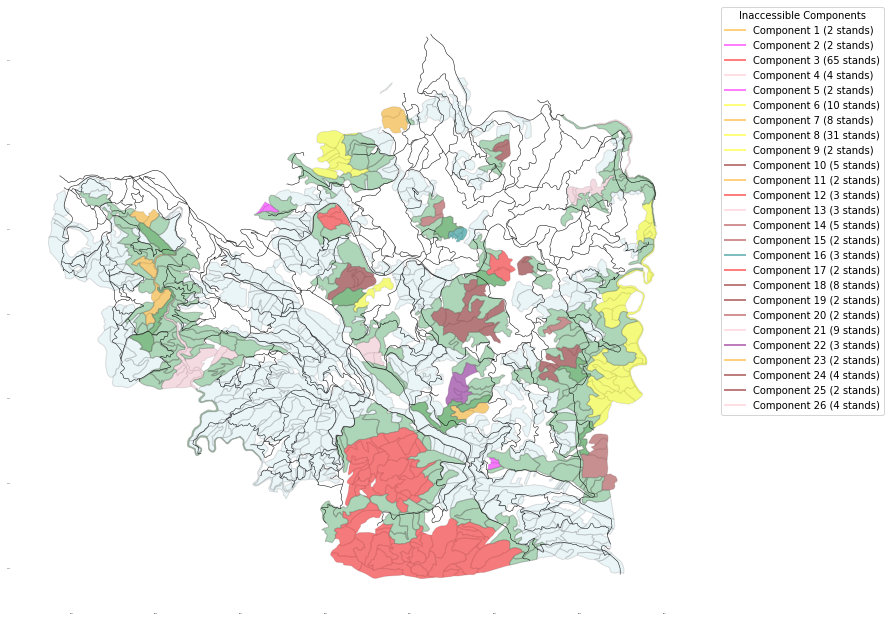

In [42]:
# Create a plot
fig, ax = plt.subplots(figsize=(12, 12))

legend_handles = []

# Plot the allroads layer first (background layer)
allroads_gdf.plot(ax=ax, color='black', linewidth=0.5, label='Roads', alpha=1)
allstands_gdf.plot(ax=ax, color='lightblue', edgecolor='grey', alpha=0.25, label='Stands')

# Loop through each connected component and plot
for comp_id, component in components_dict.items():  # Using components_dict
    component_gdf = stands_gdf[stands_gdf['ID_UG'].isin(component)]
    
    color = colors[comp_id % len(colors)]
    
    component_gdf.plot(ax=ax, color=color, alpha=0.5)

    legend_handles.append(Line2D([0], [0], color=color, alpha=.5, lw=2, label=f'Component {comp_id} ({len(component)} stands)'))

# Plot the accessible neighboring stands
combined_gdf[combined_gdf['access'] == 'accessible'].plot(ax=ax, color='forestgreen', edgecolor='grey', alpha=0.3, label='Accessible Neighboring Stand')

# Add a legend
ax.legend(handles=legend_handles, title="Inaccessible Components", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Save the plot
plt.savefig("all_components_and_neighbors_with_roads.png", bbox_inches='tight')

# Show the plot
plt.show()

## 🔗 find overlaps between newly created segments

### [helper function] find overlapping pairs

In [43]:
# Function to check for overlaps between segments
def find_overlapping_segments(segments_dict):
    overlapping_pairs = []
    
    # Iterate over each pair of segments to check for overlap
    for comp1, segment1 in segments_dict.items():
        for comp2, segment2 in segments_dict.items():
            if comp1 != comp2:  # Avoid comparing the same component with itself
                if segment1.unary_union.intersects(segment2.unary_union):
                    # Append the component names (i.e., IDs of the intersecting components)
                    overlapping_pairs.append((comp1, comp2))
    
    return overlapping_pairs

In [44]:
overlapping_pairs = find_overlapping_segments(all_combi_components)
print(len(overlapping_pairs), 'overlapping pairs in total')
for ov_pair in overlapping_pairs: print(ov_pair)

30 overlapping pairs in total
('1', '7')
('4', '26')
('5', '14')
('7', '1')
('7', '21')
('8', '14')
('8', '20')
('8', '24')
('8', '26')
('9', '10')
('9', '13')
('10', '9')
('13', '9')
('14', '5')
('14', '8')
('15', '16')
('16', '15')
('17', '18')
('18', '17')
('18', '22')
('20', '8')
('20', '24')
('21', '7')
('22', '18')
('22', '23')
('23', '22')
('24', '8')
('24', '20')
('26', '4')
('26', '8')


### visualize overlaps

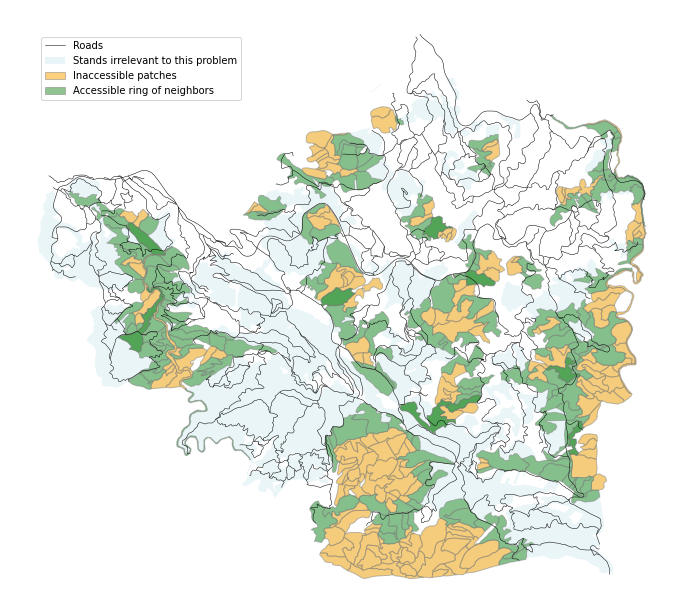

In [45]:
# Create a single plot for all components and neighbors
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the allroads layer first (background layer)
allroads_gdf.plot(ax=ax, color='black', linewidth=0.5, label='Roads', alpha=1)
allstands_gdf.plot(ax=ax, color='lightblue', label='Stands', alpha=0.25)

# Plot all components and neighbors with different colors
combined_gdf[combined_gdf['access'] == 'inaccessible'].plot(ax=ax, color='orange', edgecolor='grey', label='Inaccessible Stand', alpha=0.5)
combined_gdf[combined_gdf['access'] == 'accessible'].plot(ax=ax, color='forestgreen', edgecolor='grey', label='Accessible Neighboring Stand', alpha=0.5)

legend_handles = [
    Line2D([0], [0], color='black', lw=0.5, label='Roads', alpha=1),
    Patch(facecolor='lightblue', label='Stands irrelevant to this problem', alpha=0.25),
    Patch(facecolor='orange', edgecolor='grey', label='Inaccessible patches', alpha=0.5),
    Patch(facecolor='forestgreen', edgecolor='grey', label='Accessible ring of neighbors', alpha=0.5)
]

# Add a custom legend to distinguish between components and neighbors
ax.legend(handles=legend_handles, bbox_to_anchor=(0.05, 0.95), loc='upper left', borderaxespad=0.)

# Remove the axes for a clean plot
ax.set_axis_off()

# Save the plot as a PNG image
plt.savefig(f"all_components_and_neighbors_with_roads.png", bbox_inches='tight')

# Show the plot
plt.show()

### TO DO look at this in QGIS and decide which to merge

### [helper function] merge overlaps

In [46]:
# Function to merge detected overlapping segments
def merge_overlapping_segments(segments_dict, comp1, comp2):
    # Merge the components
    merged_component = gpd.GeoDataFrame(pd.concat([segments_dict[comp1], segments_dict[comp2]], ignore_index=True))
    
    # Ensure the merged GeoDataFrame has the correct CRS
    merged_component.set_crs(segments_dict[comp1].crs, allow_override=True)
    
    # Name the merged component
    merged_name = f"merged_{comp1}_{comp2}"
    
    # Add merged component to the dictionary
    segments_dict[merged_name] = merged_component
    
    # Delete the old components from the dictionary
    del segments_dict[comp1]
    del segments_dict[comp2]
    
    print(f'Merged: {comp1} and {comp2} into {merged_name}')
    
    return segments_dict


### TO DO merge overlaps

Repeat the process until no more overlaps are detected
while True:
    overlapping_pairs = find_overlapping_segments(all_combi_components)
    
    if not overlapping_pairs:  # No more overlaps detected
        break
    
    # Output the first overlapping pair
    comp1, comp2 = overlapping_pairs[0]
    print(f"Overlap detected between components {comp1} and {comp2}")
    
    # Merge the first overlapping pair
    all_combi_components = merge_overlapping_segments(all_combi_components, comp1, comp2)
    
    # Re-run overlap detection after each merge
    print("Re-running overlap check after merge...")


## 🌊 River segmentation

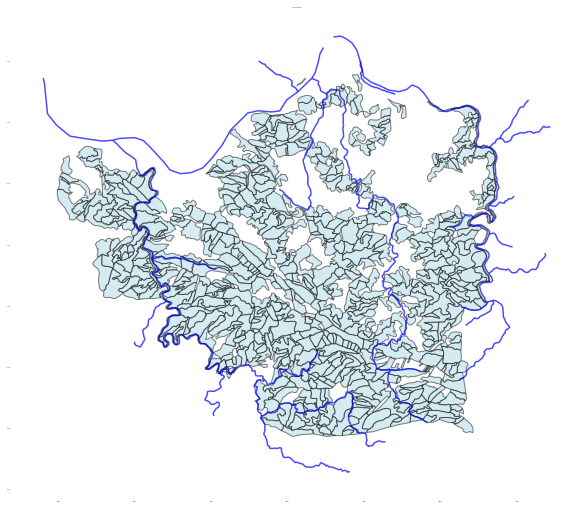

In [47]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the geometries of the stands
allstands_gdf.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.5)

# Plot the rivers 
rivers_gdf.plot(ax=ax, color='blue', alpha=0.7)

plt.title("Stands with Rivers")
plt.show()

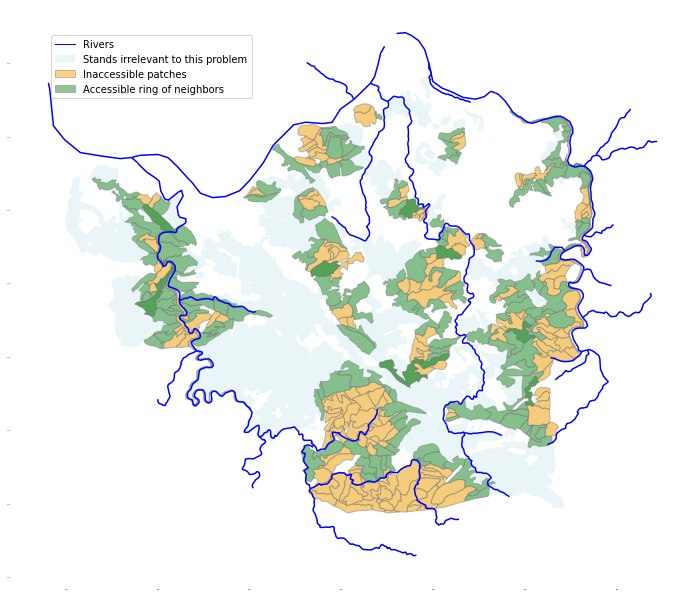

In [48]:
# Create a single plot for all components and neighbors
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the allroads layer first (background layer)
allstands_gdf.plot(ax=ax, color='lightblue', label='Stands', alpha=0.25)

# Plot the rivers layer (background layer)
rivers_gdf.plot(ax=ax, color='blue', label='Rivers', alpha=1)

# Plot the stands that are inaccessible (assuming 'access' column with value 'inaccessible')
combined_gdf[combined_gdf['access'] == 'inaccessible'].plot(ax=ax, color='orange', edgecolor='grey', label='Inaccessible Stand', alpha=0.5)

# Plot the stands that are accessible neighbors (assuming 'access' column with value 'accessible')
combined_gdf[combined_gdf['access'] == 'accessible'].plot(ax=ax, color='forestgreen', edgecolor='grey', label='Accessible Neighboring Stand', alpha=0.5)

# Custom legend handles for the legend
legend_handles = [
    Line2D([0], [0], color='blue', lw=1, label='Rivers', alpha=1),
    Patch(facecolor='lightblue', label='Stands irrelevant to this problem', alpha=0.25),
    Patch(facecolor='orange', edgecolor='grey', label='Inaccessible patches', alpha=0.5),
    Patch(facecolor='forestgreen', edgecolor='grey', label='Accessible ring of neighbors', alpha=0.5)
]

# Add a custom legend to distinguish between components and neighbors
ax.legend(handles=legend_handles, bbox_to_anchor=(0.05, 0.95), loc='upper left', borderaxespad=0.)

# Save the plot as a PNG image
plt.savefig(f"fall_components_and_neighbors_with_roads.png", bbox_inches='tight')

# Show the plot
plt.show()

#### ✂️ split by rivers


    # Check for intersections with river_gdf
    if segment_gdf.geometry.intersects(rivers_gdf.unary_union).any():
        print(f"Component {i+1} intersects with a river.")
        # split_component_by_river(component_gdf, rivers_gdf, i, folders)

#### [helper function] split by rivers

In [49]:
def split_component_by_river(component_gdf, river_gdf, component_id, folders):
    """
    Splits a component that intersects with a river into sub-components along the river geometry.
    
    Parameters:
    - component_gdf: GeoDataFrame of the component to split.
    - river_gdf: GeoDataFrame containing the river geometries.
    - component_id: Unique identifier for the component.
    - folders: Dictionary containing paths to save visualizations and shapefiles.
    
    Returns:
    None
    """
    # Iterate over the rivers to split the component
    for j, river in enumerate(river_gdf.geometry):  # Iterate through rivers
        # Check for intersection for each geometry in component_gdf
        for idx, component_geom in component_gdf.iterrows():
            if component_geom['geometry'].intersects(river):  # Check for intersection
                # Split the component along the river using intersection
                split_geometries = component_geom['geometry'].intersection(river)
                
                if isinstance(split_geometries, MultiPolygon):  # If there are multiple parts
                    for sub_idx, part in enumerate(split_geometries, start=1):
                        # Create a new GeoDataFrame for the split part
                        split_gdf = gpd.GeoDataFrame(geometry=[part], crs=component_gdf.crs)
                        split_gdf['ID_UG'] = f"{component_id}_part_{j+1}_{chr(65+sub_idx-1)}"  # Label as Component_X_A, Component_X_B
                        
                        # Save the new sub-component as a shapefile
                        split_gdf.to_file(os.path.join(folders["geometries"], f"component_{component_id}_part_{j+1}_{chr(65+sub_idx-1)}.shp"))
                        
                        # Visualize and save the sub-component
                        fig, ax = plt.subplots(figsize=(10, 10))
                        fig.patch.set_facecolor('white')
                        ax.set_facecolor('white')
                        split_gdf.plot(ax=ax, color='orange', edgecolor='grey', linewidth=1)
                        ax.set_title(f"Component {component_id} Part {chr(65+sub_idx-1)}")
                        ax.axis('off')
                        plt.tight_layout()
                        plt.savefig(os.path.join(folders["visualizations"], f"component_{component_id}_part_{j+1}_{chr(65+sub_idx-1)}.png"), dpi=300)
                        plt.close(fig)
                else:
                    # If only a single part, save it directly
                    component_gdf['geometry'] = split_geometries
                    component_gdf['ID_UG'] = f"{component_id}_part_{j+1}_A"  # Label as Component_X_A
                    
                    # Save the sub-component as a shapefile
                    component_gdf.to_file(os.path.join(folders["geometries"], f"component_{component_id}_part_{j+1}_A.shp"))
                    
                    # Visualize and save the sub-component
                    fig, ax = plt.subplots(figsize=(10, 10))
                    fig.patch.set_facecolor('white')
                    ax.set_facecolor('white')
                    component_gdf.plot(ax=ax, color='orange', edgecolor='grey', linewidth=1)
                    ax.set_title(f"Component {component_id} Part A")
                    ax.axis('off')
                    plt.tight_layout()
                    plt.savefig(os.path.join(folders["visualizations"], f"component_{component_id}_part_{j+1}_A.png"), dpi=300)
                    plt.close(fig)
